In [ ]:
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
try:
  import optuna
except ModuleNotFoundError:
  !pip install optuna
  !pip install optuna-integration[lightgbm]
  import optuna
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
from lightgbm import LGBMClassifier
import optuna.integration.lightgbm as lgb_optuna
import lightgbm as lgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

In [ ]:
data_filename = '/content/drive/MyDrive/thesis/data/depr_suic_google_gemma-2-9b-it_layer31_width16k.npz'
data_path = os.path.realpath(data_filename)
data = np.load(data_path, allow_pickle=True)
all_texts = data['texts'].tolist()
all_classes = data['classes'].tolist()
del data

In [ ]:
all_classes = [1 if x=='suicide' else 0 for x in all_classes]

In [ ]:
texts_train, texts_test, y_train, y_test = train_test_split(
    all_texts,
    all_classes,
    test_size=2500,
    random_state=42,
    stratify=all_classes
)

In [ ]:
texts_train, texts_val, y_train, y_val = train_test_split(
    texts_train,
    y_train,
    test_size=2500,
    random_state=42,
    stratify=y_train
)

In [ ]:
X_train_tfidf = vectorizer.fit_transform(texts_train)
X_val_tfidf = vectorizer.transform(texts_val)
X_test_tfidf = vectorizer.transform(texts_test)

In [ ]:
clf = LGBMClassifier(
    random_state=42,
    n_jobs=6,
    verbose=-1
)
clf.fit(X_train_tfidf, y_train)
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_tfidf), digits=3))
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_tfidf), digits=3))

              precision    recall  f1-score   support

           0      0.782     0.782     0.782      1250
           1      0.782     0.782     0.782      1250

    accuracy                          0.782      2500
   macro avg      0.782     0.782     0.782      2500
weighted avg      0.782     0.782     0.782      2500

              precision    recall  f1-score   support

           0      0.770     0.758     0.764      1250
           1      0.761     0.774     0.767      1250

    accuracy                          0.766      2500
   macro avg      0.766     0.766     0.766      2500
weighted avg      0.766     0.766     0.766      2500



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
clf = LGBMClassifier(
    random_state=42,
    n_jobs=6,
    verbose=-1
)

clf.fit(X_train_tfidf, y_train)

selector = SelectFromModel(clf, prefit=True, max_features=500)
selected_feature_indices = selector.get_support(indices=True)

X_train_selected = selector.transform(X_train_tfidf)
X_val_selected = selector.transform(X_val_tfidf)
X_test_selected = selector.transform(X_test_tfidf)

print(X_train_selected.shape, X_val_selected.shape, X_test_selected.shape)

(35000, 500) (2500, 500) (2500, 500)


In [ ]:
clf = LGBMClassifier(
    random_state=42,
    n_jobs=6,
    verbose=-1
)
clf.fit(X_train_selected, y_train)
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_selected), digits=3))
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_selected), digits=3))

              precision    recall  f1-score   support

           0      0.774     0.779     0.777      1250
           1      0.778     0.773     0.775      1250

    accuracy                          0.776      2500
   macro avg      0.776     0.776     0.776      2500
weighted avg      0.776     0.776     0.776      2500

              precision    recall  f1-score   support

           0      0.773     0.760     0.766      1250
           1      0.764     0.777     0.770      1250

    accuracy                          0.768      2500
   macro avg      0.768     0.768     0.768      2500
weighted avg      0.768     0.768     0.768      2500



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
train_data = lgb.Dataset(X_train_selected, label=y_train)
valid_data = lgb.Dataset(X_val_selected, label=y_val, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
}

tuner = lgb_optuna.LightGBMTuner(
    params,
    train_data,
    valid_sets=valid_data,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50)],
    optuna_seed=42,
    show_progress_bar=True,
)

tuner.run()

In [ ]:
best_params = tuner.best_params
print(f"Best params: {best_params}")
print(f"Best score: {tuner.best_score}")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 11, 'feature_fraction': 0.516, 'bagging_fraction': 0.6894021319323672, 'bagging_freq': 1, 'min_child_samples': 50}
Best score: 0.45765269087049565


In [ ]:
best_params = {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 11, 'feature_fraction': 0.516, 'bagging_fraction': 0.6894021319323672, 'bagging_freq': 1, 'min_child_samples': 50}

In [ ]:
clf = lgb.train(
    {**best_params},
    lgb.Dataset(X_train_selected, label=y_train),
    num_boost_round=1000,
    valid_sets=lgb.Dataset(X_val_selected, label=y_val),
    callbacks=[lgb.early_stopping(50)]
    )

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.457653


In [ ]:
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_selected) > 0.5, digits=3))

              precision    recall  f1-score   support

           0      0.785     0.787     0.786      1250
           1      0.787     0.784     0.785      1250

    accuracy                          0.786      2500
   macro avg      0.786     0.786     0.786      2500
weighted avg      0.786     0.786     0.786      2500



In [ ]:
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_selected) > 0.5, digits=3))

              precision    recall  f1-score   support

           0      0.772     0.767     0.770      1250
           1      0.769     0.774     0.771      1250

    accuracy                          0.770      2500
   macro avg      0.770     0.770     0.770      2500
weighted avg      0.770     0.770     0.770      2500



In [ ]:
svd = TruncatedSVD(n_components=500, random_state=42)

In [ ]:
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [ ]:
train_data = lgb.Dataset(X_train_svd, label=y_train)
valid_data = lgb.Dataset(X_val_svd, label=y_val, reference=train_data)

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
}

tuner = lgb_optuna.LightGBMTuner(
    params,
    train_data,
    valid_sets=valid_data,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50)],
    optuna_seed=42,
    show_progress_bar=True,
)

tuner.run()

[I 2026-01-26 14:56:28,591] A new study created in memory with name: no-name-3a22dc74-3fbb-45fb-8bf7-2553ed28c2ca
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  14%|#4        | 1/7 [00:09<00:58,  9.67s/it]

Early stopping, best iteration is:
[411]	valid_0's binary_logloss: 0.477391
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  29%|##8       | 2/7 [00:19<00:49,  9.92s/it]

Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.489401
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  43%|####2     | 3/7 [00:48<01:14, 18.55s/it]

Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.485047
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  57%|#####7    | 4/7 [01:48<01:45, 35.00s/it]

Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.487261
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  71%|#######1  | 5/7 [02:05<00:56, 28.23s/it]

Early stopping, best iteration is:
[325]	valid_0's binary_logloss: 0.486351
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391:  86%|########5 | 6/7 [02:19<00:23, 23.42s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.482086
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.477391: 100%|##########| 7/7 [02:37<00:00, 22.54s/it]


Early stopping, best iteration is:
[317]	valid_0's binary_logloss: 0.483685


num_leaves, val_score: 0.477391:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:   5%|5         | 1/20 [00:13<04:20, 13.72s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.488933
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  10%|#         | 2/20 [00:36<05:46, 19.22s/it]

Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.497228
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  15%|#5        | 3/20 [01:29<09:43, 34.30s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.491753
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  20%|##        | 4/20 [01:34<06:07, 22.97s/it]

Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.488369
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  25%|##5       | 5/20 [01:43<04:29, 17.98s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.490787
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  30%|###       | 6/20 [01:58<03:55, 16.82s/it]

Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.490203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  35%|###5      | 7/20 [02:13<03:30, 16.17s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.491321
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  40%|####      | 8/20 [02:40<03:55, 19.59s/it]

Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.483709
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  45%|####5     | 9/20 [03:30<05:23, 29.37s/it]

Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.497245
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  50%|#####     | 10/20 [03:59<04:51, 29.15s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.495602
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  55%|#####5    | 11/20 [04:13<03:41, 24.63s/it]

Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.483848
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  60%|######    | 12/20 [04:43<03:27, 25.99s/it]

Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.501732
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  65%|######5   | 13/20 [05:05<02:53, 24.78s/it]

Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.492865
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  70%|#######   | 14/20 [05:19<02:09, 21.52s/it]

Early stopping, best iteration is:
[378]	valid_0's binary_logloss: 0.485052
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  75%|#######5  | 15/20 [05:37<01:43, 20.73s/it]

Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.498524
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  80%|########  | 16/20 [05:53<01:16, 19.14s/it]

Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.483782
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  85%|########5 | 17/20 [06:49<01:30, 30.13s/it]

Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.482853
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  90%|######### | 18/20 [07:12<00:56, 28.06s/it]

Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.482853
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391:  95%|#########5| 19/20 [07:26<00:23, 23.98s/it]

Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.492521
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.477391: 100%|##########| 20/20 [07:47<00:00, 23.40s/it]


Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 0.491418


bagging, val_score: 0.477391:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.477391:  10%|#         | 1/10 [00:09<01:26,  9.58s/it]

Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.484533
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.477391:  20%|##        | 2/10 [00:18<01:11,  8.95s/it]

Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.481528
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.477391:  30%|###       | 3/10 [00:29<01:11, 10.20s/it]

Early stopping, best iteration is:
[362]	valid_0's binary_logloss: 0.480599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.477391:  40%|####      | 4/10 [00:42<01:06, 11.09s/it]

Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.483192
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198:  50%|#####     | 5/10 [00:56<01:00, 12.13s/it]

Early stopping, best iteration is:
[451]	valid_0's binary_logloss: 0.476198
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198:  60%|######    | 6/10 [01:06<00:46, 11.57s/it]

Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.482598
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198:  70%|#######   | 7/10 [01:18<00:35, 11.68s/it]

Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.480039
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198:  80%|########  | 8/10 [01:27<00:21, 10.69s/it]

Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.480729
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198:  90%|######### | 9/10 [01:34<00:09,  9.65s/it]

Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.490439
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.476198: 100%|##########| 10/10 [01:45<00:00, 10.57s/it]


Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.482874


feature_fraction_stage2, val_score: 0.476198:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.476198:  33%|###3      | 1/3 [00:09<00:18,  9.09s/it]

Early stopping, best iteration is:
[338]	valid_0's binary_logloss: 0.478924
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.476198:  67%|######6   | 2/3 [00:19<00:09,  9.77s/it]

Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.483622
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.476198: 100%|##########| 3/3 [00:30<00:00, 10.04s/it]


Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.48632


regularization_factors, val_score: 0.476198:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.476198:   5%|5         | 1/20 [00:10<03:20, 10.53s/it]

Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.486421
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.476198:  10%|#         | 2/20 [00:23<03:32, 11.83s/it]

Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.481132
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.476198:  15%|#5        | 3/20 [00:31<02:50, 10.01s/it]

Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 0.486421
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.476198:  20%|##        | 4/20 [00:44<03:02, 11.43s/it]

Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.476629
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  25%|##5       | 5/20 [01:04<03:38, 14.55s/it]

Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.472964
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  30%|###       | 6/20 [01:19<03:22, 14.46s/it]

Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.481805
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  35%|###5      | 7/20 [01:30<02:56, 13.58s/it]

Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.485206
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  40%|####      | 8/20 [01:45<02:48, 14.00s/it]

Early stopping, best iteration is:
[428]	valid_0's binary_logloss: 0.477389
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  45%|####5     | 9/20 [01:54<02:16, 12.44s/it]

Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.48443
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  50%|#####     | 10/20 [02:05<02:00, 12.04s/it]

Early stopping, best iteration is:
[304]	valid_0's binary_logloss: 0.479261
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  55%|#####5    | 11/20 [02:17<01:47, 11.95s/it]

Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.485992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  60%|######    | 12/20 [02:30<01:38, 12.33s/it]

Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.484072
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  65%|######5   | 13/20 [02:43<01:27, 12.45s/it]

Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.485267
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  70%|#######   | 14/20 [02:57<01:17, 12.88s/it]

Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.480908
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  75%|#######5  | 15/20 [03:11<01:06, 13.30s/it]

Early stopping, best iteration is:
[402]	valid_0's binary_logloss: 0.480202
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  80%|########  | 16/20 [03:24<00:52, 13.11s/it]

Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.478968
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  85%|########5 | 17/20 [03:39<00:41, 13.71s/it]

Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.479871
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  90%|######### | 18/20 [03:54<00:27, 13.98s/it]

Early stopping, best iteration is:
[403]	valid_0's binary_logloss: 0.482006
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964:  95%|#########5| 19/20 [04:07<00:13, 13.67s/it]

Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.478004
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.472964: 100%|##########| 20/20 [04:18<00:00, 12.93s/it]


Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.486789


min_child_samples, val_score: 0.472964:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.472964:  20%|##        | 1/5 [00:13<00:52, 13.14s/it]

Early stopping, best iteration is:
[336]	valid_0's binary_logloss: 0.475758
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.472964:  40%|####      | 2/5 [00:28<00:43, 14.35s/it]

Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.479374
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.472964:  60%|######    | 3/5 [00:48<00:34, 17.04s/it]

Early stopping, best iteration is:
[534]	valid_0's binary_logloss: 0.477264
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.472964:  80%|########  | 4/5 [01:03<00:16, 16.14s/it]

Early stopping, best iteration is:
[397]	valid_0's binary_logloss: 0.476293
Training until validation scores don't improve for 50 rounds


min_child_samples, val_score: 0.472964: 100%|##########| 5/5 [01:19<00:00, 15.84s/it]

Early stopping, best iteration is:
[502]	valid_0's binary_logloss: 0.476171


In [ ]:
best_params = tuner.best_params
print(f"Best params: {best_params}")
print(f"Best score: {tuner.best_score}")

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 5.395670606373728, 'lambda_l2': 8.536188349289, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.9821291366519985, 'bagging_freq': 7, 'min_child_samples': 20}
Best score: 0.47296425653076923


In [ ]:
best_params = {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': 0, 'feature_pre_filter': False, 'lambda_l1': 5.395670606373728, 'lambda_l2': 8.536188349289, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.9821291366519985, 'bagging_freq': 7, 'min_child_samples': 20}

In [ ]:
clf = lgb.train(
    {**best_params},
    train_data,
    num_boost_round=1000,
    valid_sets=valid_data,
    callbacks=[lgb.early_stopping(50)]
    )

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.472964


In [ ]:
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_svd) > 0.5, digits=3))

              precision    recall  f1-score   support

           0      0.778     0.784     0.781      1250
           1      0.782     0.776     0.779      1250

    accuracy                          0.780      2500
   macro avg      0.780     0.780     0.780      2500
weighted avg      0.780     0.780     0.780      2500



In [ ]:
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_svd) > 0.5, digits=3))

              precision    recall  f1-score   support

           0      0.760     0.781     0.770      1250
           1      0.775     0.754     0.764      1250

    accuracy                          0.767      2500
   macro avg      0.767     0.767     0.767      2500
weighted avg      0.767     0.767     0.767      2500



In [ ]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
        solver = 'saga'
    else:
        l1_ratio = None
        solver = 'saga' if penalty == 'l1' else 'lbfgs'

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,
        random_state=42
    )

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    return f1_score(y_val, y_pred)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2026-01-26 15:15:05,841] A new study created in memory with name: no-name-d5b01ec1-14e4-45cf-8f19-1569d7880181
[I 2026-01-26 15:15:06,028] Trial 0 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.0009080212298985526}. Best is trial 0 with value: 0.0.
[I 2026-01-26 15:15:12,402] Trial 1 finished with value: 0.7802907915993538 and parameters: {'penalty': 'l2', 'C': 4.043907095706619}. Best is trial 1 with value: 0.7802907915993538.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2026-01-26 15:20:27,317] Trial 2 finished with value: 0.7138211382113822 and parameters: {'penalty': 'l1', 'C': 29.830676372680497}. Best is trial 1 with value: 0.7802907915993538.
[I 2026-01-26 15:20:28,188] Trial 3 finished with value: 0.7685483870967742 and parameters: {'penalty': 'l2', 'C': 0.09828556717900597}. Best is trial 1 with value: 0.7802907915993538.
[I

In [ ]:
best_params = study.best_params
print(best_params)

{'penalty': 'l1', 'C': 1.4897771403481967}


In [ ]:
best_params = {'penalty': 'l1', 'C': 1.4897771403481967}

In [ ]:
clf = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga' if best_params['penalty'] in ['l1', 'elasticnet'] else 'lbfgs',
    l1_ratio=best_params.get('l1_ratio'),
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.4897771403481967, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')

In [ ]:
print(classification_report(y_true=y_val, y_pred=clf.predict(X_val_tfidf), digits=3))

              precision    recall  f1-score   support

           0      0.788     0.805     0.796      1250
           1      0.800     0.783     0.792      1250

    accuracy                          0.794      2500
   macro avg      0.794     0.794     0.794      2500
weighted avg      0.794     0.794     0.794      2500



In [ ]:
print(classification_report(y_true=y_test, y_pred=clf.predict(X_test_tfidf), digits=3))

              precision    recall  f1-score   support

           0      0.775     0.786     0.781      1250
           1      0.783     0.772     0.778      1250

    accuracy                          0.779      2500
   macro avg      0.779     0.779     0.779      2500
weighted avg      0.779     0.779     0.779      2500



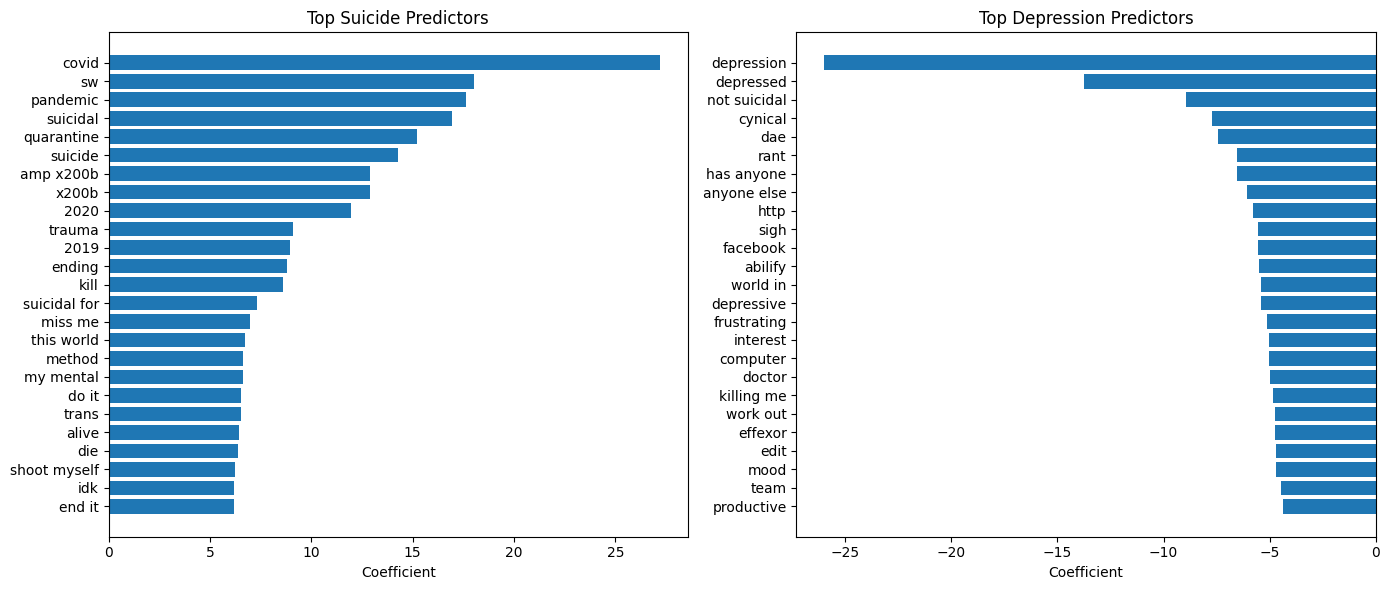

In [ ]:
def plot_top_features(model, vectorizer, n_top=25):
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_[0]

    top_positive_idx = coefs.argsort()[-n_top:][::-1]
    top_negative_idx = coefs.argsort()[:n_top]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.barh(range(n_top), coefs[top_positive_idx])
    ax1.set_yticks(range(n_top))
    ax1.set_yticklabels([feature_names[i] for i in top_positive_idx])
    ax1.set_xlabel('Coefficient')
    ax1.set_title('Top Suicide Predictors')
    ax1.invert_yaxis()

    ax2.barh(range(n_top), coefs[top_negative_idx])
    ax2.set_yticks(range(n_top))
    ax2.set_yticklabels([feature_names[i] for i in top_negative_idx])
    ax2.set_xlabel('Coefficient')
    ax2.set_title('Top Depression Predictors')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_top_features(clf, vectorizer)